In [1]:
import math, copy, sys, logging, json, time, random, os

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from MNM import DictInf

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0) 
random.seed(0)
torch.manual_seed(0)

print('torch.version', torch.__version__)
print('torch.cuda.is_available()', torch.cuda.is_available())

torch.version 1.4.0
torch.cuda.is_available() True


## This is a tutorial on the paper Metalearned Neural Memory

[arxiv](https://arxiv.org/pdf/1907.09720.pdf) by Tsendsuren Munkhdalai

We dissect the Metalearned Neural Memory Module with Local Memory Updates (MNMp) as it solves the Dictionary Inference Task

## Understanding the Dictionary Inference Task
Take the output for example:

`x = [[4 3 6 1 2 7 3 3 6 2 2 7 3 3 6 2 2 7 8 4 3 6 9 9]]`

`y = [[1 2]]`

Here the batch size is 1, the num_items = 3, item_length =2, the n_alphabet = 4

num_items translates to support set size in the paper and item_length translates to sequence length

The pair separator is 6, 6 is n_alphabet + 1 + 1, since n_alphabet = 4 the pair separator = (4+1+1) = 6. Within the first 5 elements of the vector x, it separates 4, 3 from 1, 2, meaning that 4 maps to 1 and 3 maps to 2.

This is the new mapping task that the networks needs to learn "on the fly" in order to make correct predictions

The instance separator is 7, n_alphabet + 3, of which there are 3 because num_items = 3.

The instance separator serves as the delimiter between these mapping pair examples. In this example here are the 3 pairs of the form `[_ _ 6 _ _ 7]`: 

`4 3 6 1 2 7` , `3 3 6 2 2 7`, `3 3 6 2 2 7`.

8 is the prediction separator, it occurs once after the teaching is finished. It says " now that we have shown you some examples of mappings from one integer to the other, what does `4 3 ` map to ? 

`6` is the last usage of the pair separator and `9 9` is essentially item_length occurances of the the pad aka placeholder. This pattern of, pair separator + placeholder x item_length denotes the end of the teaching + question session.

since 4 maps to 1 and 3 maps to 2, the sequence 4, 3 maps to 1, 2 which is why the target y = 1, 2

The regular case has n_alphabet = 26 so that the mappings are for terms that could be from 1 to 26, the pair separator is 28, the instance separator is 29, the prediction separator is 30 and the end of teaching + question session placeholder is 31. 

In [2]:
class Config:
    def __init__(self):
        pass
    
config = Config()
config.n_heads = 4
config.batch_size =  1
config.checkpoint = 2
config.max_iters = 10

test_generator = DictInf(batch_size=config.batch_size, max_iter=10,  
                          min_num_items=4, max_num_items=4, 
                          min_item_length=1, max_item_length=1, 
                          checkpoint=config.checkpoint)

x, y = test_generator.next() #(batch_size,),(batch_size,item_length)

print(x)
print("--------------------")
print(y)

def save_model(model,name):
    torch.save(model.state_dict(),name)
    
def load_model(model,name):
    model.load_state_dict(torch.load(name))

[[ 6 28  5 29 18 28  7 29  3 28 26 29 18 28  7 29 30 18 28 31]]
--------------------
[[7]]



## FFMemory (Feed Forward Memory)

k_w, v_w are passed to the memory function along with the rate scalar beta

their shapes are (batchsize, n_heads, dim_hidden) and (batch_size, 1)

This is the memory unit and it comes in two forms, the local update which is gradient free, and the gradient based.

Here in the FFMemoryLearned function we used the perceptron learning rule to update the memory. This is explained well here: http://hagan.okstate.edu/4_Perceptron.pdf 

## Perceptron Learning Rule

The perceptron learning rule allows you to change the weights of a linear transformation matrix in such a way as to nudge it's output closer to or away from a desired target. It does this at the level of a single perceptron.

Consider the some layer of a feed forward neural network, activations "a" = relu(Wx+b).

"a" might have several dimensions, but the first dimension of "a" is only dependant on x and the first row of W. So if you consider W to be a single row and "a" to be a single activation, then without loss of generality, what applies for this row applies to the entire matrix W and the entire vector a. 

if W = `[-1, 1]` and b = `[-1]`, you can see by plotting W`[x_1, x_2]` + b = 0 on a x_1 by x_2 axis that this is a line with slope 1 that intersects the x_1 axis at -1. This is the decision boundary because at this boundary Wx+b=0 and on either side of the boundary you are either positive or negative.  The point p1 = x_1, x_2 = 2, 1 would be evaluated as -1 if you plugged it into Wx+b and so would be negative after the activation function. 

Supposed without calculating the gradient you want to change W such that the point p1 = x_1, x_2 = 2, 1 will be classified as positive. Notice that the vector for W `[-1, 1]` points down and to the right, away from p1. That direction that vector W points in, is the direction towards the side of the decision boundary that is positive in Wx. The opposite side of the boundary is negative in Wx. if you add p1 to W you get W = `[1, 2]`, and if you add the error, target - activation = 1 - 0 = 1 to the bias, you get b = 0. 

The new line points up and to the right and will now classify p1 correctly. Wx + b = 2+2+1 = 5. Notice that b also changes in the correct direction, if you didnt change b, the resulting decision boundary `[1, 2]`x - 1 = 0 would have been a negatively sloped line that intersects the x_1 axis at x_1 = 1, whereas now that b = 1, the intersect is at 0. This update has not only rotated the vector W to point towards p1 but shifted the decision boundary downwards pulling the boundary away from p1 so taht p1 is farther within the region of positivity and therefore more positive.

$$ W_t := W_{t-1} + (target - activation) \otimes input^{T} $$

$$ b_t = b_{t-1} + (target - activation) $$

The circle with an X inside is the outer product, this fits with the shape of W since if the activation is m-dimensional, and input is n-dimensional, the W is shape mxn and the bias is shape mx1. Therefore the the update to W must be the same shape as W which is the shape you would get if you performed an outer product between (target - activation) x (input^T) = (update) which has shape (mx1)(1xn) = (mxn)

In this paper the target vector is not some kind of supervised label, instead it is a target that the feed forward neural memory learns to come up with in order to update all the layers of the neural network in such a way as to  bind the key value pair. 

In [3]:
class FFMemoryLearned(nn.Module):
    
    def __init__(self, dim_hidden):
        
        super(FFMemoryLearned, self).__init__()
        
        self.l1 = nn.Linear(dim_hidden, dim_hidden).weight.data
        self.l2 = nn.Linear(dim_hidden, dim_hidden).weight.data
        self.l3 = nn.Linear(dim_hidden, dim_hidden).weight.data
        
        self.Ws = [self.l1, self.l2, self.l3]
        self.Ws_temp = None
        
        self.expected_activation = nn.Linear(dim_hidden, 3*dim_hidden)

    def if_cuda(self):
        if next(self.parameters()).is_cuda:
            self.l1 = self.l1.cuda()
            self.l2 = self.l2.cuda()
            self.l3 = self.l3.cuda()
        self.Ws = [self.l1, self.l2, self.l3]

    def detach_mem(self):
        for W_l in self.Ws:
          W_l.detach()
        self.Ws_temp = None

    def forward(self, key):
        self.if_cuda()
        
        if self.Ws_temp is None: # is reset at beginning of every new sequence 
          self.Ws_temp = []
          for W_l in self.Ws:
            W = W_l.unsqueeze(dim=0).expand((key.shape[0], W_l.shape[0], W_l.shape[1]))
            self.Ws_temp.append(W)
            
        activations = [] # hidden activations 
        a = key
        
        for W_l in self.Ws_temp[:-1]:
          a = torch.matmul(a, W_l.transpose(1,2))
          a = torch.sigmoid(a)
          activations.append(a)
        
        value = torch.matmul(a, self.Ws_temp[-1].transpose(1,2))

        return value, activations

    def mse_loss(self, y_pred, y):
        diff = y_pred - y
        diff = diff.view(-1)
        mse = diff.dot(diff)/diff.size()[0]
        return mse

    def read(self, k, weights=None, avg=True):

        v, h_acts = self.forward(k)

        if weights is not None:
          v *= weights
        if avg:
          v = v.mean(dim=1)
        return v

    def update(self, k_w, v_w, beta_rate=0.1):  

        v_w_approx, activations = self.forward(k_w)
        
        v_w_approx = v_w_approx.contiguous()
        v_w = v_w.contiguous()
        
        reconst_loss_init = self.mse_loss(v_w_approx.view(-1, v_w_approx.shape[2]), 
                                           v_w.view(-1, v_w.shape[2]))
        
        z_pr = self.expected_activation(v_w.view(-1, v_w.shape[2]))
        z_pr = z_pr.view(v_w.shape[0], v_w.shape[1], -1)
        z_pr = torch.chunk(z_pr, 3, dim=2)
        
        if len(beta_rate.shape) < 3:
            beta_rate = beta_rate.unsqueeze(1)

        z2 = activations + [v_w_approx]
        z1 = [k_w] + activations
        Ws_t = []
        
        for W_l, z2_, z1_, z_pr in reversed(list(zip(self.Ws_temp, 
                                             z2, z1, z_pr))):
            
            z1_ = z1_*beta_rate.expand(z1_.shape)
            diff = z2_ - z_pr #(batchsize, heads, dim_hidden)
            diff = diff*(2./ (diff.shape[1]*diff.shape[2]))
            W_l = W_l - torch.matmul(diff.transpose(1,2), z1_)#- 0.0001*W_l 0.1
            Ws_t.insert(0, W_l)

        self.Ws_temp[:] = Ws_t
        
        # Run memory forward again after memory update 
        v_w_approx, activations = self.forward(k_w)
        reconst_loss = self.mse_loss(v_w_approx.view(-1, v_w_approx.shape[2]), 
                                      v_w.view(-1, v_w.shape[2]))
        
        return reconst_loss, reconst_loss_init

# MNMp (Metalearned Neural Memory with local memory updates)

As opposed to gradient based updates

The embedded sequence x of input vectors x_t is processed sequentially by MNMp as x_t having shape (batch size, n_units) in the order of the sequence. 

The first neural network that processes the input vector x_t is 

`self.lstm_l1 = nn.LSTMCell(n_units+n_in_mem, n_units)`

where the class parameters are `torch.nn.LSTMCell(input_size, hidden_size, bias=True)`

This is because the input to the LSTMCell, a single layer LSTM, is the concatenation of the input x_t with the memory readout vector v_t-1 of shape `(batch size, self.n_in_mem)`

The first time that the MNMp forward pass is used, the initial memory readout vector - self.v, and LSTM controller hidden states - self.h_lstm and self.c_lstm is initialized as zero vectors, it is then updated thereafter with each subsequent forward pass x_t.

In the paper this LSTM controller is 

$$h_t = LSTM(x_t, v^{r}_{t-1}, h_{t-1})$$

In PyTorch the LSTMCell takes an input and a hidden state (hidden state, cell state) tuple, so this mathematical term appears as 

`self.h_lstm, self.c_lstm = self.lstm_l1(torch.cat([x, self.v], dim=1), (self.h_lstm, self.c_lstm))`

The hidden state output of the LSTM controller is placed through an affine transformation and tanh non-linearity to produce a large vector that is then separated into the interaction vectors.

$$[k^{r}_{t,1} . . . k^{r}_{t,H}; k^{w}_{t,1} . . .  k^{w}_{t,H}; v^{w}_{t,1}. . . v^{w}_{t,H}; β'_t] = tanh(W_v h_t + b_v)$$

`int_vecs = torch.tanh(self.heads_l2(self.h_lstm))`

For each sampled inthe batch, there are H sets of 3 vectors, the read key, write key and write value, plus one rate vector beta_.

The rate vector is projected to a scalar "rate", called beta in the range 0 to 1. The operation

`n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()`

The rate vector is separated from the other interaction vectors in this step, 
this portion of the interaction vectors n_k_v consists of the write key-value pairs,
and the read key, it does not include the read value, because this has to bre read from the memory function using the read key in the `self.v_r = self.memfunc.read(k_r)` step. 

`
beta_,n_k_v=torch.split(int_vecs,[self.dim_hidden,self.dim_hidden*self.n_heads*3],dim=1)
`

The shape of the n_k_v undergoes these shape changes 

(batchsize, dim_hidden*n_heads*3)->(batchsize,n_heads,dim_hidden*3)
`n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()`
        
`k_w, v_w, k_r = torch.chunk(n_k_v, 3, dim=2)`

each of these tensors k_w, v_w, k_r is of shape (batchsize, n_heads, dim_hidden)

k_w, v_w are passed to the memory update function along with the rate scalar beta. How hte Memory is updated is explained in the FFMemory section

`re_const_loss, re_const_loss_init = self.memfunc.update(k_w, v_w, beta_rate=beta)`

The controller hidden state is updated using both the previous hidden state and the read value produced from the memory

`h_lstm = self.read_out(torch.cat([self.h_lstm, self.v_r], dim=1))`


In [4]:
class MNMp(nn.Module):

    def __init__(self, dim_hidden, n_heads = 4):
        
        """ dim_hidden is the hidden size of the LSTM controller,
            the Memory Network, and the interaction vectors
            n_heads is the number of interaction heads """

        super(MNMp, self).__init__()
        
        self.dim_hidden = dim_hidden
        self.n_heads = n_heads
        
        self.control = nn.LSTMCell(dim_hidden*2, dim_hidden)
        
        dim_concat_interact = dim_hidden*n_heads*3 + dim_hidden
        self.interaction = nn.Linear(dim_hidden, dim_concat_interact)
        
        self.memfunc = FFMemoryLearned(dim_hidden)
        
        self.kv_rate = nn.Linear(dim_hidden, 1)
        
        self.read_out = nn.Linear(dim_hidden+dim_hidden, dim_hidden)
        
        self.v_r = None
        self.h_lstm = None
        self.c_lstm = None
            
    def initialize_v_h_c(self, batch_size):
        
            self.v_r = torch.zeros((batch_size, self.dim_hidden)).float()
            self.h_lstm = torch.zeros((batch_size, self.dim_hidden)).float()
            self.c_lstm = torch.zeros((batch_size, self.dim_hidden)).float()
            
            if next(self.parameters()).is_cuda:
                self.v_r = self.v_r.cuda()
                self.h_lstm = self.h_lstm.cuda()
                self.c_lstm = self.c_lstm.cuda()
            
    def forward(self, x):
        
        self.initialize_v_h_c(x.shape[0])

        self.h_lstm, self.c_lstm = self.control(torch.cat([x, self.v_r], dim=1), 
                                                (self.h_lstm, self.c_lstm))
        
        int_vecs = torch.tanh(self.interaction(self.h_lstm))
            
        
        beta_, n_k_v = torch.split(int_vecs, 
                                   [self.dim_hidden, 
                                   self.dim_hidden*self.n_heads*3],
                                   dim=1)  
        
        beta = torch.sigmoid(self.kv_rate(beta_)) #(batch_size,1)
        
        #(batchsize, dim_hidden*n_heads*3)->(batchsize,n_heads,dim_hidden*3)
        n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()
        
        # each below is shaped (batchsize, n_heads, dim_hidden)
        k_w, v_w, k_r = torch.chunk(n_k_v, 3, dim=2)
        
        # This is the right to memory operation
        reconst_loss, reconst_loss_init = self.memfunc.update(k_w, v_w, 
                                                                beta_rate=beta)
        # This is the read from memory operation
        self.v_r = self.memfunc.read(k_r)
        
        h_lstm = self.read_out(torch.cat([self.h_lstm, self.v_r], dim=1))
        
        return h_lstm, reconst_loss, reconst_loss_init

In [5]:
mnm = MNMp(dim_hidden=8, n_heads=2)

embed_idx = nn.Embedding(num_embeddings=test_generator.n_vocab,embedding_dim=8) 

In [6]:
# MNMp sandbox
batch = test_generator.next()
x = batch[0]
y = batch[1]

print(x)
print("--------------------")
print(y)

input_x = torch.LongTensor(x) # (batch size, sequence length)
input_x = embed_idx(input_x) # (batch size, sequence length, n_units)
input_x = torch.chunk(input_x, input_x.shape[1], dim=1) # tuple of size sequence length

for x in input_x:
    x = x.squeeze(1) #(batch_size, n_units)
    h, const_loss, re_const_loss_init = mnm(x)
         

[[12 28  8 29  3 28 15 29  3 28 15 29  9 28 20 29 30 12 28 31]]
--------------------
[[8]]


# MNMpSeq2Seq 

The highest level of the model. The train function runs the forward pass of the model. 

## The Forward Pass

the first step is that the sequence token is embedded. In the DictInf class you see that the vocabulary size of the embedding is self.n_alphabet+5 where self.n_alphabet = 26 for the number of characters in the alphabet.  n_units is the hidden size of the embedding. 

The embedded sequence is processed sequentially by MNMp as shape (batch size, n_units) in the order of the sequence. 

In [7]:
class MNMpSeq2Seq(nn.Module):

    def __init__(self, n_vocab, dim_hidden, n_heads):
        
        super(MNMpSeq2Seq, self).__init__()

        self.embed_idx = nn.Embedding(n_vocab, dim_hidden)
        self.mnm = MNMp(dim_hidden, n_heads)
        self.w_out = nn.Linear(dim_hidden, n_vocab)
        
        self.n_vocab = n_vocab
        self.dim_hidden = dim_hidden
        
    def forward(self, input_x):
        
        self.mnm.memfunc.detach_mem()
        
        input_x = torch.LongTensor(input_x) # (batch size, sequence length)
        
        if next(self.parameters()).is_cuda:
            input_x = input_x.cuda()
            
        input_x = self.embed_idx(input_x) # (batch size, sequence length, n_units)
        
        # tuple of size sequence length where element are shape (batch_size, 1, n_units)
        input_x = torch.chunk(input_x, input_x.shape[1], dim=1) 
        
        h_all = []
        reconst_loss_all = 0
        reconst_loss_init_all = 0
        for x in input_x:
            x = x.squeeze(1) #(batch_size, dim_hidden)
            h_lstm, reconst_loss, reconst_loss_init = self.mnm(x)
            reconst_loss_all += reconst_loss
            reconst_loss_init_all += reconst_loss_init
            h_all.append(h_lstm.unsqueeze(1))

        reconst_loss_all /= len(input_x)
        reconst_loss_init_all /= len(input_x)
        
        return h_all, reconst_loss_all, reconst_loss_init_all

    def train(self, input_x, trg):

        h_all, reconst_loss_all, reconst_loss_init_all = self.forward(input_x)

        trg = torch.LongTensor(trg)
        trg_len = trg.shape[1]
        
        h = h_all[-trg_len:]
        h = torch.cat(h, dim=1)
        y = self.w_out(h)
        y = torch.transpose(y, 1, 2)
        y_preds = y.argmax(1).cpu().numpy()

        if next(self.parameters()).is_cuda:
            trg = trg.cuda()
            
        loss = F.cross_entropy(y, trg)

        return y_preds, loss, reconst_loss_all, reconst_loss_init_all

In [8]:
model = MNMpSeq2Seq(n_vocab=32, dim_hidden=64, n_heads=4)
load_model(model,"modelstate/mnm_64_4_gpu.pth")
model = model.cuda()

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [ 1 11 24 15] [ 1 11 24  9]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> [22 20 16 20] [22 20 16 20]


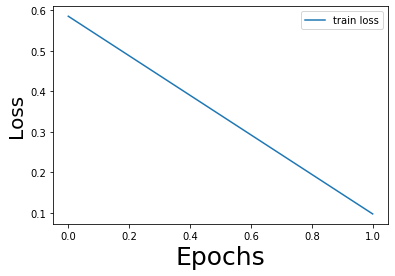

In [10]:
train_generator = DictInf(batch_size=64, max_iter=100,
#train_generator = DictInf(batch_size=4, max_iter=1,  
                          min_num_items=4, max_num_items=4, 
                          min_item_length=1, max_item_length=1, 
                          checkpoint=20)

optimizer = optim.Adam(model.parameters())

total_loss = 0
total_reconst_loss = 0
reconst_loss_init_all = 0
total_acc = 0

loss_all_list = []
acc_list = []

train_generator.cur_iter = 0

while train_generator.cur_iter <= train_generator.max_iter:
    
    start = time.time()
    batch = train_generator.next()
    x = batch[0]
    y = batch[1]

    y_preds, loss, reconst_loss, reconst_loss_init = model.train(x, y)

    y_true = y.reshape((-1, ))
    y_preds = y_preds.reshape((-1, ))
    print(type(y_true), type(y_preds), y_true, y_preds)
    acc = accuracy_score(y_true, y_preds)
    acc_list.append(acc)

    model.zero_grad()
    loss_t = loss + reconst_loss
    loss_t.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()

    total_loss += loss.float().item()
    total_reconst_loss += reconst_loss.float().item()
    reconst_loss_init_all += reconst_loss_init.float().item()
    total_acc += acc

    loss_all_list.append(loss.float().item())
    end = time.time()
    runtime = end - start
    
    if train_generator.cur_iter % train_generator.checkpoint == 0:

        print ("iter: ", train_generator.cur_iter)
        print ("train acc: ", total_acc/train_generator.checkpoint)
        print ("train loss: ", total_loss/train_generator.checkpoint)
        print ("train memory reconst_loss (pre-update):", 
               reconst_loss_init_all/train_generator.checkpoint)
        print ("train memory reconst_loss (post-update):",  
               total_reconst_loss/train_generator.checkpoint)
        print ("memory reconst_loss gain:", 
               (reconst_loss_init_all - total_reconst_loss)/train_generator.checkpoint)
        print("runtime", runtime)
        total_loss = 0
        total_reconst_loss = 0
        reconst_loss_init_all = 0
        total_acc = 0
        
plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=20)
plt.plot(loss_all_list, label='train loss')
plt.legend()
plt.show()

In [19]:
save_model(model,"modelstate/mnm_64_4_gpu.pth")
model = model.cpu()      
save_model(model,"modelstate/mnm_64_4_cpu.pth")

In [10]:
model2 = MNMpSeq2Seq(n_vocab=32, dim_hidden=64, n_heads=4)
load_model(model2,"modelstate/mnm_64_4_cpu.pth")
model2 = model2.cuda()
model2.mnm.memfunc.Ws = model.mnm.memfunc.Ws

In [11]:
batch = train_generator.next()
x = batch[0]
y = batch[1]

y_preds2, loss2, reconst_loss2, reconst_loss_init2 = model2.train(x, y)
#y_preds, loss, reconst_loss, reconst_loss_init = model.train(x, y)

y_true = y.reshape((-1, ))
y_preds2 = y_preds2.reshape((-1, ))
acc = accuracy_score(y_true, y_preds2)

print("accuracy",acc)
print("loss", loss_t.data)
print(loss2.data, reconst_loss2.data, reconst_loss_init2.data)
#print(loss.data, reconst_loss.data, reconst_loss_init.data)

accuracy 0.84375
loss tensor(0.5993, device='cuda:0')
tensor(0.5642, device='cuda:0') tensor(0.0900, device='cuda:0') tensor(0.1345, device='cuda:0')


In [19]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name)

embed_idx.weight
mnm.control.weight_ih
mnm.control.weight_hh
mnm.control.bias_ih
mnm.control.bias_hh
mnm.interaction.weight
mnm.interaction.bias
mnm.memfunc.expected_activation.weight
mnm.memfunc.expected_activation.bias
mnm.kv_rate.weight
mnm.kv_rate.bias
mnm.read_out.weight
mnm.read_out.bias
w_out.weight
w_out.bias
